# Station Outlier filter

This notebook shows the "station outlier filter" to detect... 

The original R code stems from https://github.com/LottedeVos/PWSQC/. 

Publication:
de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. _Geophysical Research Letters_, 46(15), 8820-8829.

The idea of the filter is to... 

In [1]:
# Import packages

import poligrain as plg
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pypwsqc as pws

In [2]:
#%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#read output data from FZ and HI filters
ds_pws = xr.open_dataset('C:/Users/a002461/OPENSENSE/data/HI_flagged_data_compressed.nc')

#slice to time of interest
ds_pws = ds_pws.sel(time = slice("2017-07-01 00:00","2017-08-01 00:00"))

In [4]:
ds_pws

<xarray.Dataset>
Dimensions:       (time: 8929, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2017-07-01 ... 2017-08-01
  * id            (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation     (id) <U3 ...
    latitude      (id) float64 ...
    longitude     (id) float64 ...
    x             (id) float64 ...
    y             (id) float64 ...
Data variables:
    rainfall      (id, time) float64 ...
    nbrs_not_nan  (id, time) float32 ...
    reference     (id, time) float64 ...
    hi_flag       (id, time) float32 ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [5]:
#this should be an input parameter to the function!

#strict: including only stations that passed the FZ and HI test (fz_flag == 0, hi_flag == 0)
#setting 1 and -1 to NaN
filtered_rain = ds_pws.rainfall.where(ds_pws.hi_flag != 0, np.NaN).to_dataset() #this should be done for FZ flag as well!

#flex: including stations that passed the FZ and HI filters, and stations that do not have enough neighbours to apply the filters
#setting 1 to -NaN
#filtered_rain = ds_pws.rainfall.where(ds_pws.hi_flag == 1, np.NaN).to_dataset() 
filtered_rain

<xarray.Dataset>
Dimensions:    (time: 8929, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-08-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude   (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude  (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) float64 0.101 0.202 0.101 0.202 ... nan nan nan nan

In [6]:
#load distance matrix
distance_matrix = xr.open_dataset('C:/Users/a002461/OPENSENSE/data/distance_matrix.nc')
distance_matrix = distance_matrix.load()

#this renaming should be done before saving the distance matrix...r
distance_matrix = distance_matrix.rename({"__xarray_dataarray_variable__": "distance"})
distance_matrix

<xarray.Dataset>
Dimensions:      (id: 134, id_neighbor: 134)
Coordinates:
  * id           (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
Data variables:
    distance     (id, id_neighbor) float64 0.0 518.8 532.0 ... 4.265e+03 0.0

# Apply SO filter

In [7]:
#Set parameters
mint = 4032 
mrain = 100 
mmatch = 200
gamma = 0.15
beta = 0.2
nstat = 5

In [8]:
#Boolean 2D data array, defining neihbours within max_distance for all stations
max_distance = 10e3
neighbor_matrix = distance_matrix < max_distance

In [9]:
# Default Bias Correction Factor
dbc = 1

In [10]:
# Boolean 2D array (id, time) of true (rain > 0) or false (rain =< 0) for all stations and timesteps
rainy_timesteps = filtered_rain.rainfall > 0 

In [11]:
#cumulative rainy timesteps per station 
cum_rainy_timesteps = rainy_timesteps.cumsum(dim="time")

In [13]:
%%time

#initalize with empty numpy array
so_flag = np.empty_like(ds_pws.rainfall)

for i, station_id in enumerate(["ams1"]): #for i, station_id in enumerate(filtered_rain.id.data): enumerate(["ams1", "ams21", "ams88"])
    
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc

    #THE NEIGHBOR PICKING SHOULD BE DONE EARLIER IN THE CODE! Already in FZ filter
    #picking stations within range, excluding itself
    nbrs_within_range = (distance_matrix.sel(id = station_id).distance < max_distance) & (distance_matrix.sel(id = station_id).distance > 0)
    
    #pick neighbors ids, drop all NanNs
    neighbors = distance_matrix.sel(id = station_id).distance.where(nbrs_within_range, drop = True).id_neighbor

        #if less than nstat neighbors within max_distance. NINT?!?!
        # if there are not enough stations nearby or no observations in 'Nint',!!!!
        #if neighbors.sizes["id_neighbor"] < nstat:
            #ds_pws["so_flag"] = -1

    for timestep in range(mint, mint+1): #ds_pws.sizes["time"]

        #fixed evaluation period
        evaluation_period_start = timestep - mint + 1
        evaluation_period_end = timestep
        
        #BELOW DOES NOT WORK YET - VARIABLE EVALUATION PERIOD#
        #if cum_rainy_timesteps[timestep] - cum_rainy_timesteps[timestep - mint + 1] >= mrain:
            #print('there ARE at least mrain rainy timesteps within the last mint timesteps', timestep)
            #evaluation_period_start = timestep - mint + 1
            #evaluation_period_end = timestep
            
        #else: #variable evaluation period
            #print('there ARE NOT at least mrain rainy timesteps within the last mint timesteps', k)
            #if cum_rainy_timestepss[timestep] - mrain >= 0:
                #evaluation_period_start = np.where(cum_rainy_timestepss == (cum_rainy_timestepss[timestep] - mrain))[0][0]
                #print('so the start of the evaluation period is', idx_rain_start)
                #evaluation_period_end = timestep
                #print('so the lenght of the evaluation period is', idx_rain_end-idx_rain_start)
        
        #number of rainy timesteps within evaulation period from neighbors
        matches = rainy_timesteps.sel(id = neighbors).isel(time = slice(evaluation_period_start, evaluation_period_end)).sum().data

        if matches < mmatch:
            so_flag[i, timestep] = -1

        else: 
            
            corr_values = np.zeros_like(neighbors, dtype = float)
            bias_values = np.zeros_like(neighbors, dtype = float)

            #loop over neighbors 
            for j, neighbor_id in enumerate(neighbors.id_neighbor.data):
                # pearson correlation with neighboring stations
                corr = xr.corr(ds_pws.rainfall.sel(id = station_id).isel(time = slice(evaluation_period_start, evaluation_period_end)), ds_pws.rainfall.sel(id = neighbor_id).isel(time = slice(evaluation_period_start, evaluation_period_end)))
                corr_values[j] = corr.data #???

                #rain_pws - rain_reference (neighboring stations, radar)
                delta_r = ds_pws.rainfall.sel(id = station_id).isel(time = slice(evaluation_period_start, evaluation_period_end)) - ds_pws.rainfall.sel(id = neighbor_id).isel(time = slice(evaluation_period_start, evaluation_period_end))

                bias = np.nanmean(delta_r) / np.nanmean(ds_pws.rainfall.sel(id = neighbor_id).isel(time = slice(evaluation_period_start, evaluation_period_end)))
                bias_values[j] = bias
                
                #Janni:
                #netatmo_hour[idx_rain_start:idx_rain_end, i] - netatmo_hour[idx_rain_start:idx_rain_end, neighbors[j]]
    
                #Lotte:
                #R_pws - R_ref where R_ref is corresponding reference time series in the overlying radar pixel

                #If the median of the r values falls short of threshold γ, the SO flag is set to 1. 
                median_correlation = np.median(corr_values)

                if median_correlation > gamma:
                    bias_values[np.isinf(bias_values)] = np.nan #how to make this line work?
                    median_bias = np.nanmedian(bias_values) # median of bias of indivial bias to all neigbors
                    BCFnew = 1 / (1 + median_bias)
                    if np.abs(np.log(BCFnew / BCF_prev)) > np.log(1 + beta):
                        BCF_prev = BCFnew
                        
                # if pearson correlation is too low, then it is a "station outlier"
                else:
                    so_flag[i, timestep] = 1

C:\Users\a002461\AppData\Local\pypoetry\Cache\virtualenvs\pypwsqc-jhedPHd3-py3.10\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\a002461\AppData\Local\pypoetry\Cache\virtualenvs\pypwsqc-jhedPHd3-py3.10\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<timed exec>:61: RuntimeWarning: Mean of empty slice
C:\Users\a002461\AppData\Local\pypoetry\Cache\virtualenvs\pypwsqc-jhedPHd3-py3.10\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\a002461\AppData\Local\pypoetry\Cache\virtualenvs\pypwsqc-jhedPHd3-py3.10\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, 

CPU times: total: 1.11 s
Wall time: 1.11 s


In [14]:
# Check here if there are still empty entries in SO_flag

In [15]:
ds_pws["so_flag"] = (("id", "time"),so_flag)
ds_pws

<xarray.Dataset>
Dimensions:       (time: 8929, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2017-07-01 ... 2017-08-01
  * id            (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation     (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude      (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude     (id) float64 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x             (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y             (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall      (id, time) float64 0.101 0.202 0.101 0.202 ... 0.0 0.0 0.0 0.0
    nbrs_not_nan  (id, time) float32 ...
    reference     (id, time) float64 ...
    hi_flag       (id, time) float32 -1.0 -1.0 -1.0 -1.0 ... 0.0 0.0 0.0 0.0
    so_flag       (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

# implementation with variable evaluation period

In [194]:
#initalize with empty numpy array
so_flag = np.empty_like(ds_pws.rainfall)

for i, station_id in enumerate(["ams45"]): #enumerate(["ams1", "ams45", "ams17"]): enumerate(filtered_rain.id.data)
    print(station_id)
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc
    nbrs_within_range = (distance_matrix.sel(id = station_id).distance < max_distance) & (distance_matrix.sel(id = station_id).distance > 0)
    neighbors = distance_matrix.sel(id = station_id).distance.where(nbrs_within_range, drop = True).id_neighbor

    #for timestep in range(mint, mint+10): #range(mint, ds_pws.dims["time"]): 
    for j, timestep in enumerate(ds_pws.time.isel(time =  slice(mint, -1)).data, start = mint): 
        #På nåt sätt behöver du fylla upp alla entries upp till mint med -1

        #fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps
        if cum_rainy_timesteps.sel(id = station_id, time = timestep) - cum_rainy_timesteps.sel(id = station_id).isel(time = j-mint+1) >= mrain:
            #print('there ARE at least mrain rainy timesteps within the last mint timesteps')
            evaluation_period_start = timestep - mint + 1
            evaluation_period_end = timestep

        #variable evaluation period if less than mrain rainy timesteps in the last mint timesteps (but before the considered period starts)
        elif (cum_rainy_timesteps.sel(id = station_id).isel(time = j).data - mrain) > 0: 
            #print('there ARE NOT at least mrain rainy timesteps within the last mint timesteps')
            
            #THE TWO ROWS BELOW SHOULD BE FIXED!!!!
            #evaluation_period_start = cum_rainy_timesteps.sel(id = station_id).where(cum_rainy_timesteps.sel(id = station_id).data == (cum_rainy_timesteps.sel(id = station_id).isel(time = j).data - mrain)).dropna(dim = "time").time.data
            #evaluation_period_start = 

            #last occuring time step where cum_rainy_timesteps >= 0
            #print(evaluation_period_start[-1])

            evaluation_period_end = timestep

        else:
            #print('this wont work sorry') 
            #assign -1 to SO filter, we are in the 'warm up period' of the filter
            #På nåt sätt behöver du fylla upp alla entries upp till mint med -1
            so_flag[i, j] = -1
            

ams45


In [211]:
so_flag[i,j-5000]

0.0

In [184]:
#seems that this works incorrectly. Ams45 get no -1 in the xarray dataset.
ds_pws["so_flag"] = (("id", "time"),so_flag)
ds_pws

<xarray.Dataset>
Dimensions:       (time: 8929, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2017-07-01 ... 2017-08-01
  * id            (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation     (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude      (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude     (id) float64 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x             (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y             (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall      (id, time) float64 0.101 0.202 0.101 0.202 ... 0.0 0.0 0.0 0.0
    nbrs_not_nan  (id, time) float32 ...
    reference     (id, time) float64 ...
    hi_flag       (id, time) float32 -1.0 -1.0 -1.0 -1.0 ... 0.0 0.0 0.0 0.0
    so_flag       (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

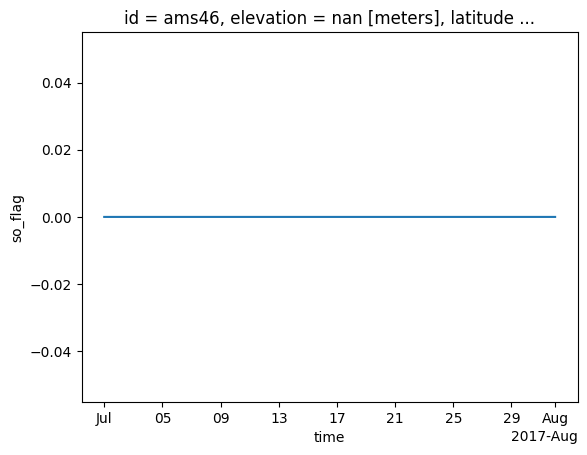

In [189]:
ds_pws.so_flag.sel(id = "ams46").plot()

In [133]:
#initalize with empty numpy array
so_flag = np.empty_like(ds_pws.rainfall)

for i, station_id in enumerate(["ams1", "ams45", "ams17"]): #enumerate(["ams1", "ams2", "ams3"]): enumerate(filtered_rain.id.data)
    print(station_id)
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc
    nbrs_within_range = (distance_matrix.sel(id = station_id).distance < max_distance) & (distance_matrix.sel(id = station_id).distance > 0)
    neighbors = distance_matrix.sel(id = station_id).distance.where(nbrs_within_range, drop = True).id_neighbor

    #for timestep in range(mint, mint+10): #range(mint, ds_pws.dims["time"]): 
    for j, timestep in enumerate(ds_pws.time.isel(time =  slice(mint, -1)).data, start = mint): 
        #print(timestep)
        
        if cum_rainy_timesteps.sel(id = station_id).isel(time = timestep) - cum_rainy_timesteps.sel(id = station_id).isel(time = timestep-mint+1) >= mrain:
            print('there ARE at least mrain rainy timesteps within the last mint timesteps')
            print('number of rainy timesteps:')
            a = cum_rainy_timesteps.sel(id = station_id).isel(time = timestep).data - cum_rainy_timesteps.sel(id = station_id).isel(time = timestep-mint+1).data
            print(a)
            evaluation_period_start = timestep - mint + 1
            evaluation_period_end = timestep

        elif (cum_rainy_timesteps.sel(id = station_id).isel(time = timestep).data - mrain) > 0: #ADD STATEMENT FROM DEV SCRATCHPAD:
            print('there ARE NOT at least mrain rainy timesteps within the last mint timesteps')
            #print(cum_rainy_timesteps.sel(id = station_id).isel(time = timestep).data - mrain)
            #b = cum_rainy_timesteps.sel(id = station_id).isel(time = timestep).data - cum_rainy_timesteps.sel(id = station_id).isel(time = timestep-mint+1).data
            print(b)
            
            evaluation_period_start = cum_rainy_timesteps.sel(id = station_id).where(cum_rainy_timesteps.sel(id = station_id).data == (cum_rainy_timesteps.sel(id = station_id).isel(time = timestep).data - mrain)).dropna(dim = "time").time.data

            #last occuring time step where cum_rainy_timesteps >= 0
            print(evaluation_period_start[-1])

            #find timestep with mrain less accumulated rainy timesteps than current time step. By setting this as the start of the evaluation period, we get a time window with mrain rainy timesteps included.
            
            #c = cum_rainy_timesteps.sel(id = station_id).where(cum_rainy_timesteps.sel(id = station_id).data == (cum_rainy_timesteps.sel(id = station_id).isel(time = timestep).data - mrain)) #.dropna(dim = "time").time.data
            
            #c = cum_rainy_timesteps.sel(id = station_id).where(cum_rainy_timesteps.sel(id = station_id).data == (cum_rainy_timesteps.sel(id = station_id).isel(time = timestep).data - mrain)).dropna(dim = "time").time.data
            #evaluation_period_start =  np.unique(cum_rainy_timesteps.sel(id = station_id).where(cum_rainy_timesteps.sel(id = station_id) == mrain, drop = True).data)
            #print(evaluation_period_start)
            #evaluation_period_start = np.where(cum_rainy_timesteps.sel(id = station_id).data == (cum_rainy_timesteps.sel(id = station_id).isel(time = timestep).data - mrain))[0][0]
            #print('so the start of the evaluation period is', idx_rain_start)
            evaluation_period_end = timestep
            #print('so the lenght of the evaluation period is', idx_rain_end-idx_rain_start)
            #b = evaluation_period_end - evaluation_period_start
            #print(b)

        else:
            print("this wont work sorry") #assign -1 to SO filter, we are before the considered period
            print(cum_rainy_timesteps.sel(id = station_id).isel(time = timestep).data - mrain)

ams1


IndexError: index 1500076800000000000 is out of bounds for axis 0 with size 8929